In [4]:
import warnings
warnings.filterwarnings('ignore')
import string
import re
from unicodedata import normalize
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dense,Embedding,RepeatVector,TimeDistributed
from keras.callbacks import EarlyStopping
from nltk.translate.bleu_score import corpus_bleu
import pandas as pd
from string import punctuation
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [6]:
total_sentences = 10000

# Load the dataset
dataset = pd.read_csv("eng_-french.csv", nrows = total_sentences)

# What proportion of the sentences will be used for the test set
test_proportion = 0.1
train_test_threshold = int( (1-test_proportion) * total_sentences)

printmd(f'## {total_sentences} "parallel sentences" will be loaded (original sentence + its translation)')
printmd(f'## {train_test_threshold} "parallel sentences" will be used to train the model')
printmd(f'## {total_sentences-train_test_threshold} "parallel sentences" will be used to test the model')

## 10000 "parallel sentences" will be loaded (original sentence + its translation)

## 9000 "parallel sentences" will be used to train the model

## 1000 "parallel sentences" will be used to test the model

In [7]:
# Shuffle the dataset
dataset = dataset.sample(frac=1, random_state=0)
dataset.iloc[1000:1010]

,English words/sentences,French words/sentences
1554,Let me die.,Laisse-moi mourir.
2087,He's a slob.,C'est un flemmard.
5470,I have to try.,Il faut que j'essaie.
2363,I was naive.,Je fus crédule.
7570,He is bankrupt.,Il est en faillite.
6427,That's a fact.,C'est un fait.
1651,Talk to me!,Parlez-moi !
4164,Keep talking.,Continuez de parler.
1231,I broke it.,Je l'ai cassée.
9232,Tom is a judge.,Tom est juge.


In [8]:
def clean(string):
    # Clean the string
    string = string.replace("\u202f"," ") # Replace no-break space with space
    string = string.lower()
    
    # Delete the punctuation and the numbers
    for p in punctuation + "«»" + "0123456789":
        string = string.replace(p," ")
        
    string = re.sub('\s+',' ', string)
    string = string.strip()
           
    return string

# Clean the sentences
dataset["English words/sentences"] = dataset["English words/sentences"].apply(lambda x: clean(x))
dataset["French words/sentences"] = dataset["French words/sentences"].apply(lambda x: clean(x))

# Select one part of the dataset
dataset = dataset.values
dataset = dataset[:total_sentences]

# split into train/test
train, test = dataset[:train_test_threshold], dataset[train_test_threshold:]

# Define the name of the source and of the target
# This will be used in the outputs of this notebook
source_str, target_str = "French", "English"

# The index in the numpy array of the source and of the target
idx_src, idx_tar = 1, 0

In [9]:
# Display the result after cleaning
pd.DataFrame(dataset[1000:1010])

,0,1
0,let me die,laisse moi mourir
1,he s a slob,c est un flemmard
2,i have to try,il faut que j essaie
3,i was naive,je fus crédule
4,he is bankrupt,il est en faillite
5,that s a fact,c est un fait
6,talk to me,parlez moi
7,keep talking,continuez de parler
8,i broke it,je l ai cassée
9,tom is a judge,tom est juge


In [10]:
def create_tokenizer(lines):
    # fit a tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
def max_len(lines):
    # max sentence length
    return max(len(line.split()) for line in lines)

def encode_sequences(tokenizer, length, lines):
    # encode and pad sequences
    X = tokenizer.texts_to_sequences(lines) # integer encode sequences
    X = pad_sequences(X, maxlen=length, padding='post') # pad sequences with 0 values
    return X
 
def encode_output(sequences, vocab_size):
    # one hot encode target sequence
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y
 
# Prepare target tokenizer
tar_tokenizer = create_tokenizer(dataset[:, idx_tar])
tar_vocab_size = len(tar_tokenizer.word_index) + 1
tar_length = max_len(dataset[:, idx_tar])
printmd(f'\nTarget ({target_str}) Vocabulary Size: {tar_vocab_size}')
printmd(f'Target ({target_str}) Max Length: {tar_length}')

# Prepare source tokenizer
src_tokenizer = create_tokenizer(dataset[:, idx_src])
src_vocab_size = len(src_tokenizer.word_index) + 1
src_length = max_len(dataset[:, idx_src])
printmd(f'\nSource ({source_str}) Vocabulary Size: {src_vocab_size}')
printmd(f'Source ({source_str}) Max Length: {src_length}\n')
 
# Prepare training data
trainX = encode_sequences(src_tokenizer, src_length, train[:, idx_src])
trainY = encode_sequences(tar_tokenizer, tar_length, train[:, idx_tar])
trainY = encode_output(trainY, tar_vocab_size)

# Prepare test data
testX = encode_sequences(src_tokenizer, src_length, test[:, idx_src])
testY = encode_sequences(tar_tokenizer, tar_length, test[:, idx_tar])
testY = encode_output(testY, tar_vocab_size)


Target (English) Vocabulary Size: 2099

Target (English) Max Length: 5


Source (French) Vocabulary Size: 4039

Source (French) Max Length: 12


In [15]:
def create_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    # Create the model
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_shape=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model
 
# Create model
model = create_model(src_vocab_size, tar_vocab_size, (12,), tar_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')

history = model.fit(trainX, 
          trainY, 
          epochs=200, 
          batch_size=64, 
          validation_split=0.1, 
          verbose=1,
          callbacks=[
                        EarlyStopping(
                        monitor='val_loss',
                        patience=10,
                        restore_best_weights=True
                    )
            ])

Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 5.3546 - val_loss: 3.5567
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 3.3591 - val_loss: 3.3275
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 3.1254 - val_loss: 3.1209
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 2.9187 - val_loss: 2.9950
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 2.7760 - val_loss: 2.9061
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 2.6320 - val_loss: 2.7920
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 2.4970 - val_loss: 2.7012
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 2.3637 - val_loss: 2.5964
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 2.2317 - val_loss: 2.5055
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 2.0999 - val_loss: 2.3964
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 1.9447 - val_loss: 2.3127
Epoch 12/200
127/127 ━━━━━━━━

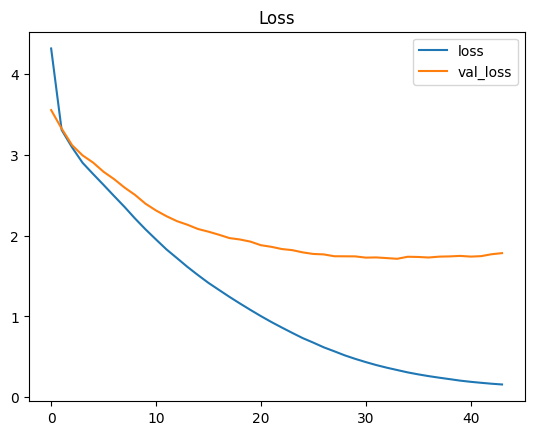

In [16]:
pd.DataFrame(history.history).plot()
plt.title("Loss")
plt.show()

In [17]:
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        print(f'{raw_src:30} {raw_target:25} {translation}')
        if i >= limit: # Display some of the result
            break
 
# test on some training sequences
print('### Result on the Training Set ###')
compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
compare_prediction(model, tar_tokenizer, testX, test)

### Result on the Training Set ###
FRENCH (SOURCE)                ENGLISH (TARGET)          AUTOMATIC TRANSLATION IN ENGLISH

nous en savons assez           we know enough            we know enough
garde ton sang froid           stay calm                 keep calm
je ne pleurerai pas            i won t cry               i won t cry
je ne suis pas contente        i m not happy             i m not happy
moi je veux ça                 i want that               i want that
j étais tellement heureuse     i was so happy            i was so happy
j aime le printemps            i like spring             i like spring
c est mon garçon               that s my boy             that s my dog
mille mercis                   many thanks               thanks a bunch
quelle horreur                 how horrible              how horrible
soyez satisfaites              be content                be content
toi décide                     you decide                you decide
je m en suis remis             i r

In [18]:
# It takes long to compute the BLEU Score

def bleu_score(model, tokenizer, sources, raw_dataset):
    # Get the bleu score of a model
    actual, predicted = [], []
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        actual.append([raw_target.split()])
        predicted.append(translation.split())
        
    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_dic

# Compute the BLEU Score
bleu_train = bleu_score(model, tar_tokenizer, trainX, train)
bleu_test = bleu_score(model, tar_tokenizer, testX, test)

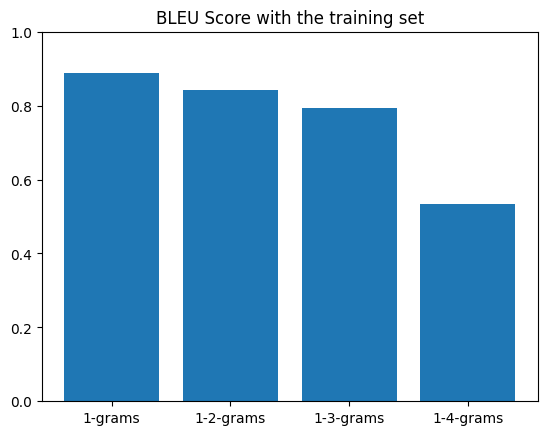

In [19]:
plt.bar(x = bleu_train.keys(), height = bleu_train.values())
plt.title("BLEU Score with the training set")
plt.ylim((0,1))
plt.show()

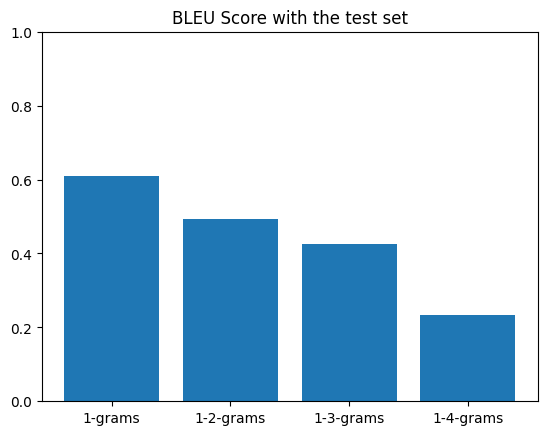

In [20]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the test set")
plt.ylim((0,1))
plt.show()